<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/vqe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color="blue">**Variational Quantum Eigensolver**

Video: [Molecular Simulation with VQE](https://youtu.be/fJUzXbr5MTo?si=1JMrO5SZ0LRPjtYK)

Pennylane: [A brief overview of VQE](https://pennylane.ai/qml/demos/tutorial_vqe/)

Pennylane: [Accelerating VQEs with quantum natural gradient](https://pennylane.ai/qml/demos/tutorial_vqe_qng/)

In [ ]:
!pip install pennylane
import pennylane as qml

In [ ]:
!pip install cirq -q
import cirq

In [ ]:
import matplotlib.pyplot as plt
from jax import numpy as np
import jax
jax.config.update("jax_platform_name", "cpu")
jax.config.update('jax_enable_x64', True)

symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])

In [5]:
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

Number of qubits =  4
The Hamiltonian is    (-0.2427450126094144) [Z2]
+ (-0.2427450126094144) [Z3]
+ (-0.042072551947439224) [I0]
+ (0.1777135822909176) [Z0]
+ (0.1777135822909176) [Z1]
+ (0.12293330449299361) [Z0 Z2]
+ (0.12293330449299361) [Z1 Z3]
+ (0.16768338855601356) [Z0 Z3]
+ (0.16768338855601356) [Z1 Z2]
+ (0.17059759276836803) [Z0 Z1]
+ (0.1762766139418181) [Z2 Z3]
+ (-0.044750084063019925) [Y0 Y1 X2 X3]
+ (-0.044750084063019925) [X0 X1 Y2 Y3]
+ (0.044750084063019925) [Y0 X1 X2 Y3]
+ (0.044750084063019925) [X0 Y1 Y2 X3]


In [6]:
dev = qml.device("lightning.qubit", wires=qubits)

In [8]:
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0]


In [7]:
@qml.qnode(dev)
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])
    return qml.expval(H)

In [9]:
def cost_fn(param):
    return circuit(param, wires=range(qubits))

The library [optax](https://optax.readthedocs.io/en/latest/) offers different optimizers. Here we use a basic gradient-descent optimizer.

In [10]:
import optax

max_iterations = 100
conv_tol = 1e-06

opt = optax.sgd(learning_rate=0.4)

In [11]:
theta = np.array(0.)

# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

opt_state = opt.init(theta)

for n in range(max_iterations):

    gradient = jax.grad(cost_fn)(theta)
    updates, opt_state = opt.update(gradient, opt_state)
    theta = optax.apply_updates(theta, updates)

    angle.append(theta)
    energy.append(cost_fn(theta))

    conv = np.abs(energy[-1] - energy[-2])

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

/usr/local/lib/python3.10/dist-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Step = 0,  Energy = -1.12799983 Ha
Step = 2,  Energy = -1.13466246 Ha
Step = 4,  Energy = -1.13590595 Ha
Step = 6,  Energy = -1.13613667 Ha
Step = 8,  Energy = -1.13617944 Ha
Step = 10,  Energy = -1.13618736 Ha
Step = 12,  Energy = -1.13618883 Ha

Final value of the ground-state energy = -1.13618883 Ha

Optimal value of the circuit parameter = 0.2089


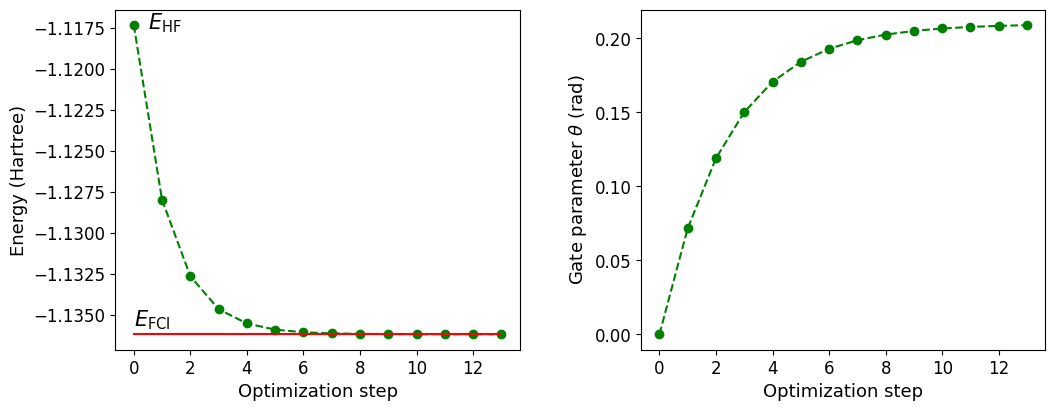

In [13]:
import matplotlib.pyplot as plt


fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()